### Google Play Rating Visualize Importance

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

### Data preparation

In [2]:
data0 = pd.read_csv("../DataSets/Google Play Rating Visualize Importance/Google_data_cleaned.csv")
display(data0[0:2].T)
print(data0.columns.tolist())
data0=data0.dropna()

,0,1
Unnamed: 0,0,1
app,Photo Editor & Candy Camera & Grid & ScrapBook,Coloring book moana
category,ART_AND_DESIGN,ART_AND_DESIGN
rating,4.1,3.9
reviews,159,967
installs,10000,500000
type,0,0
price,0.0,0.0
content_rating,Everyone,Everyone
genres,Art & Design,Art & Design;Pretend Play


['Unnamed: 0', 'app', 'category', 'rating', 'reviews', 'installs', 'type', 'price', 'content_rating', 'genres', 'current_ver', 'android_ver', 'size(kb)', 'update_month', 'update_year']


In [3]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object':
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [4]:
data1=labelencoder(data0.copy())

### Target setting

In [5]:
target=['rating']
dataY=data1[target]
dataX=data1.drop(['Unnamed: 0','rating'],axis=1)

In [6]:
df_columns = list(dataX.columns)
print(df_columns)

['app', 'category', 'reviews', 'installs', 'type', 'price', 'content_rating', 'genres', 'current_ver', 'android_ver', 'size(kb)', 'update_month', 'update_year']


In [7]:
trainX=dataX
trainY=dataY

In [8]:
train_df=trainX

In [9]:
train_df.columns=df_columns

In [10]:
def create_numeric_feature(input_df):
    use_columns = df_columns
    return input_df[use_columns].copy()

In [11]:
from contextlib import contextmanager
from time import time

In [12]:
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [13]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [14]:
train_feat_df = to_feature(train_df)
#test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 333.28it/s]

createcreate_numeric_feature  0.002[s]


### Model

In [15]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv,
             params: dict=None,
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'colsample_bytree': .5,
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain',
    'random_state': 71,
    'num_leaves': 62
}

In [16]:
y = trainY
ydf=pd.DataFrame(y)
ydf

,rating
0,4.1
1,3.9
2,4.7
4,4.3
5,4.4
...,...
9649,3.8
9650,4.8
9651,4.0
9653,4.5


In [17]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

    #fig,ax = plt.subplots(figsize=(6,6))
    #ax.set_title(target[i],fontsize=20)
    #ax.set_ylabel('predicted',fontsize=12)
    #ax.set_xlabel('actual',fontsize=12)
    #ax.scatter(y,oof)

C:\Users\maxim\AppData\Local\Temp\ipykernel_9412\970692798.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'l

fit fold=0  0.369[s]
Fold 0 RMSLE: 0.5121



D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fit fold=1  0.210[s]
Fold 1 RMSLE: 0.4949

fit fold=2  0.182[s]
Fold 2 RMSLE: 0.5314



D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a

fit fold=3  0.249[s]
Fold 3 RMSLE: 0.5052

fit fold=4  0.195[s]
Fold 4 RMSLE: 0.5276

--------------------------------------------------
FINISHED | Whole RMSLE: 0.5144


D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


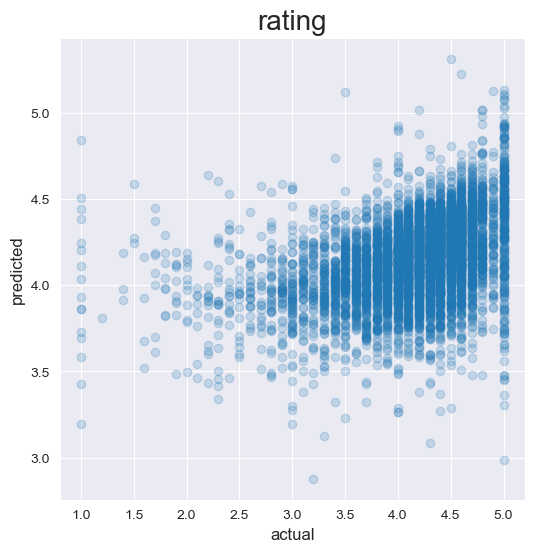

In [18]:
for i in range(1):
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(y,oof,alpha=0.2)

### Visualize Importance

In [19]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h')

    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()

    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

In [20]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    #fig, ax = visualize_importance(models, train_feat_df)
    #ax.set_title(target[i]+' Imortance',fontsize=20)

C:\Users\maxim\AppData\Local\Temp\ipykernel_9412\970692798.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'l

fit fold=0  0.347[s]
Fold 0 RMSLE: 0.5121

fit fold=1  0.172[s]
Fold 1 RMSLE: 0.4949



D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a

fit fold=2  0.181[s]
Fold 2 RMSLE: 0.5314



D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fit fold=3  0.270[s]
Fold 3 RMSLE: 0.5052

fit fold=4  0.164[s]
Fold 4 RMSLE: 0.5276

--------------------------------------------------
FINISHED | Whole RMSLE: 0.5144


D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


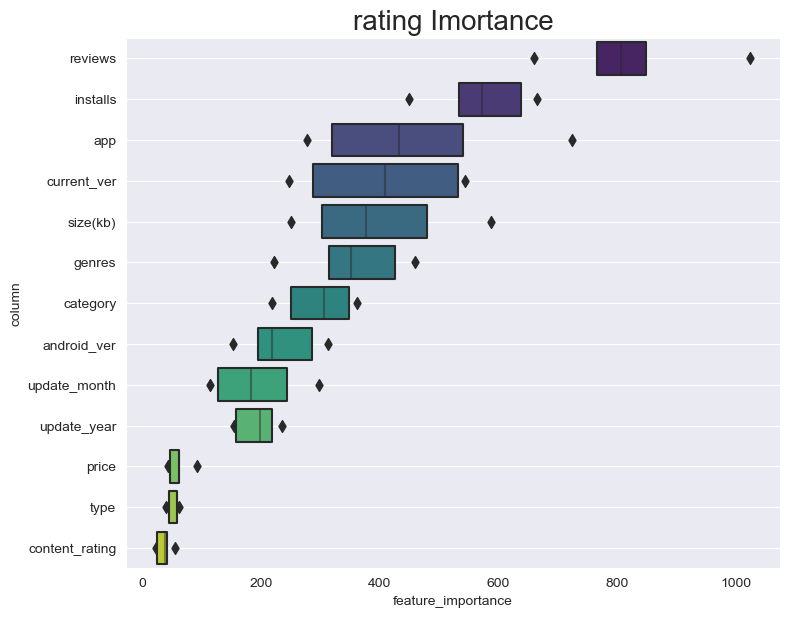

In [21]:
for i in range(1):
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

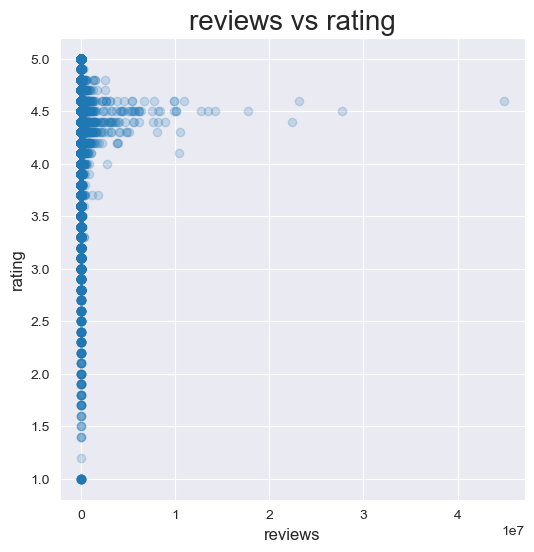

In [22]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title('reviews vs rating',fontsize=20)
ax.set_xlabel('reviews',fontsize=12)
ax.set_ylabel('rating',fontsize=12)
ax.scatter(data0['reviews'],data0['rating'],alpha=0.2)
plt.show()

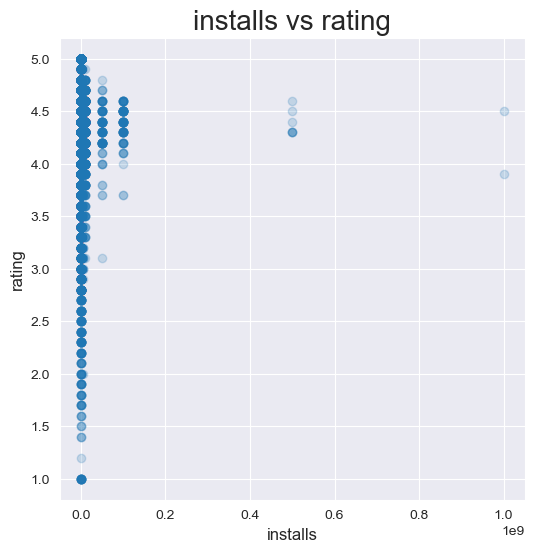

In [23]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title('installs vs rating',fontsize=20)
ax.set_xlabel('installs',fontsize=12)
ax.set_ylabel('rating',fontsize=12)
ax.scatter(data0['installs'],data0['rating'],alpha=0.2)
plt.show()